### If running in colab

In [ ]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
cd /content && rm -rf /content/rome
git clone https://github.com/kmeng01/rome rome > install.log 2>&1
pip install -r /content/rome/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [ ]:
IS_COLAB = False
try:
    import google.colab, torch, os

    IS_COLAB = True
    os.chdir("/content/rome")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

In [ ]:
! pip install transformers
! pip install accelerate
! pip install datasets

## Causal Tracing

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os, re, json
import torch, numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset

torch.set_grad_enabled(False)

In [ ]:
model_name = "gpt2-xl" 
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=IS_COLAB,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")

data/known_1000.json does not exist. Downloading from https://rome.baulab.info/data/dsets/known_1000.json


100%|██████████| 335k/335k [00:00<00:00, 2.06MB/s]


Loaded dataset with 1209 elements
Using noise level 0.13462981581687927


In [ ]:
def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")
    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

In [ ]:
def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

## **Experimenting with Relation Corruption**

In [ ]:
def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")
    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                # b = 5
                # e = 7
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

In [ ]:
def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])

    #e_range
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject) #og
    # e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], template) #imp
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

## Code to plot the results

In [ ]:
import numpy as np

def find_highly_activated(matrix):

    if torch.mean(matrix) + torch.std(matrix) >= torch.max(matrix):
      threshold = torch.mean(matrix)
    else:
      threshold = torch.mean(matrix) + torch.std(matrix)

    print("Threshold: ", threshold)

    above_threshold_indices = np.where(matrix >= threshold)

    result = [( layer_number, token_number) for token_number, layer_number in zip(above_threshold_indices[0], above_threshold_indices[1])]
    print("\nHighly Activated Neurons:")
    for x,y in result:
      print("Layer: ", x, " Token: ", y)
    print()

In [ ]:
def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind
    )
    find_highly_activated(result["scores"])
    plot_trace_heatmap(result, savepdf, modelname=modelname)


def plot_all_flow(mt, prompt, subject=None, noise=0.1, modelname=None):
    for kind in [None, "mlp", "attn"]:
        plot_hidden_flow(
            mt, prompt, subject, modelname=modelname, noise=noise, kind=kind
        )



Threshold:  tensor(0.4248)

Highly Activated Neurons:
Layer:  1  Token:  1
Layer:  2  Token:  1
Layer:  3  Token:  1
Layer:  4  Token:  1
Layer:  5  Token:  1
Layer:  6  Token:  1
Layer:  7  Token:  1
Layer:  8  Token:  1
Layer:  9  Token:  1
Layer:  10  Token:  1
Layer:  11  Token:  1
Layer:  12  Token:  1
Layer:  13  Token:  1
Layer:  14  Token:  1
Layer:  15  Token:  1
Layer:  16  Token:  1
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5
Layer:  33  Token:  5
Layer:  34  Token:  5
Layer:  35  Token:  5
Layer:  36  Token:  5
Layer:  37  Token:  5
Layer:  38  Token:  5
Layer:  39  Token:  5
Layer:  40  Token:  5
Layer:  41  Token:  5
Layer:  42  Token:  5
Layer:  43  Token:  5
Layer:  44  Token:  5
Layer:  45  Token:  5
Layer:  46  Token:  5
Layer:  47  Token:  5



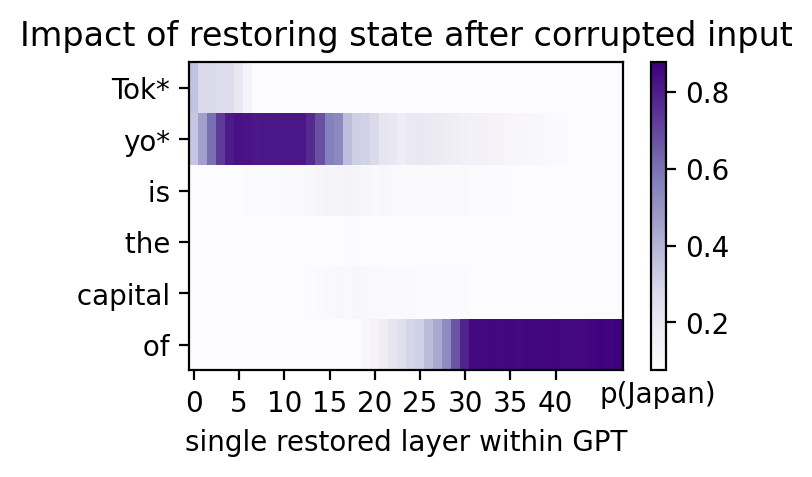

Threshold:  tensor(0.2742)

Highly Activated Neurons:
Layer:  0  Token:  0
Layer:  1  Token:  0
Layer:  2  Token:  0
Layer:  3  Token:  0
Layer:  4  Token:  0
Layer:  5  Token:  0
Layer:  0  Token:  1
Layer:  1  Token:  1
Layer:  2  Token:  1
Layer:  3  Token:  1
Layer:  4  Token:  1
Layer:  5  Token:  1
Layer:  6  Token:  1
Layer:  7  Token:  1
Layer:  8  Token:  1
Layer:  9  Token:  1
Layer:  10  Token:  1
Layer:  11  Token:  1
Layer:  12  Token:  1
Layer:  13  Token:  1
Layer:  14  Token:  1
Layer:  15  Token:  1
Layer:  16  Token:  1
Layer:  17  Token:  1
Layer:  18  Token:  1
Layer:  19  Token:  1



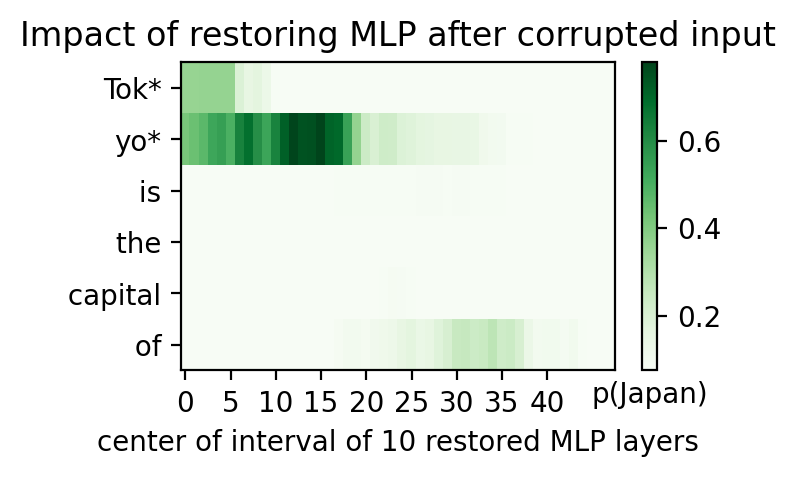

Threshold:  tensor(0.1988)

Highly Activated Neurons:
Layer:  0  Token:  1
Layer:  1  Token:  1
Layer:  2  Token:  1
Layer:  3  Token:  1
Layer:  4  Token:  1
Layer:  5  Token:  1
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  20  Token:  5
Layer:  21  Token:  5
Layer:  22  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5
Layer:  33  Token:  5
Layer:  34  Token:  5
Layer:  35  Token:  5



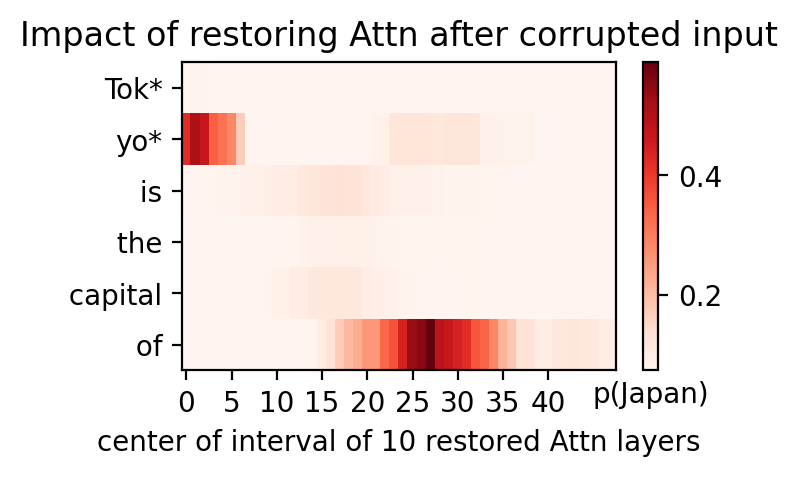

In [ ]:
plot_all_flow(mt, "Tokyo is the capital of", subject = None , noise=noise_level)

Threshold:  tensor(0.3649)

Highly Activated Neurons:
Layer:  12  Token:  5
Layer:  13  Token:  5
Layer:  14  Token:  5
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  20  Token:  5
Layer:  21  Token:  5
Layer:  22  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5
Layer:  33  Token:  5
Layer:  34  Token:  5
Layer:  35  Token:  5
Layer:  36  Token:  5
Layer:  37  Token:  5
Layer:  38  Token:  5
Layer:  39  Token:  5
Layer:  40  Token:  5
Layer:  41  Token:  5
Layer:  42  Token:  5
Layer:  43  Token:  5
Layer:  44  Token:  5
Layer:  45  Token:  5
Layer:  46  Token:  5
Layer:  47  Token:  5



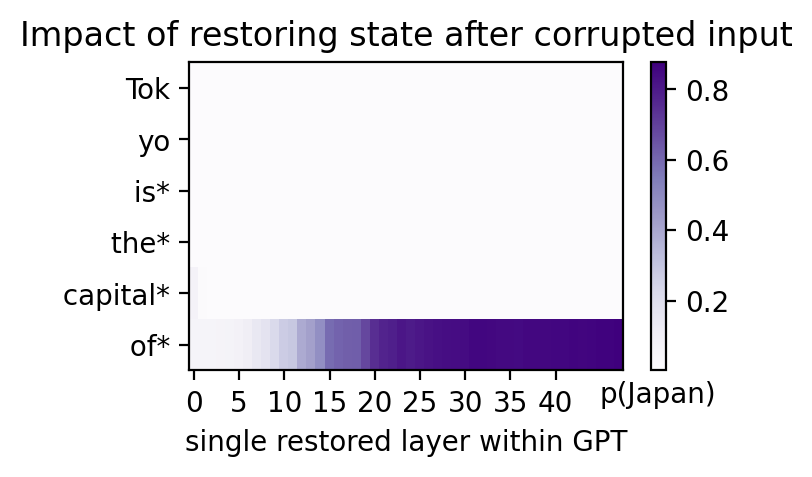

Threshold:  tensor(0.0315)

Highly Activated Neurons:
Layer:  0  Token:  4
Layer:  1  Token:  4
Layer:  2  Token:  4
Layer:  3  Token:  4
Layer:  4  Token:  4
Layer:  5  Token:  4
Layer:  0  Token:  5
Layer:  1  Token:  5
Layer:  2  Token:  5
Layer:  3  Token:  5
Layer:  4  Token:  5
Layer:  5  Token:  5
Layer:  6  Token:  5
Layer:  9  Token:  5
Layer:  10  Token:  5
Layer:  13  Token:  5
Layer:  14  Token:  5
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  21  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5



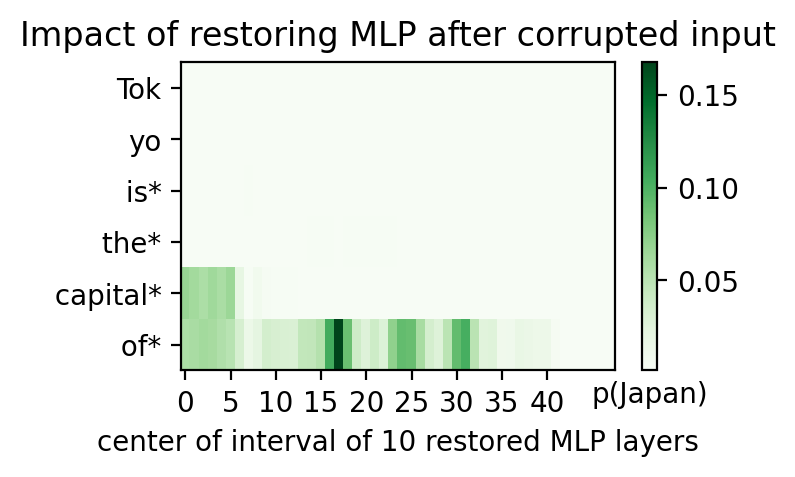

Threshold:  tensor(0.0095)

Highly Activated Neurons:
Layer:  2  Token:  5
Layer:  3  Token:  5
Layer:  4  Token:  5
Layer:  5  Token:  5
Layer:  6  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  30  Token:  5



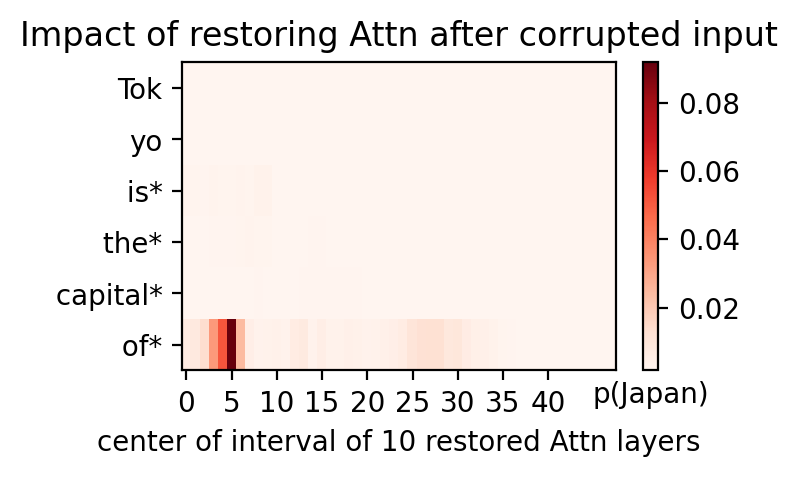

In [ ]:
plot_all_flow(mt, "Tokyo is the capital of", subject = "is the capital of" , noise=noise_level)

Threshold:  tensor(0.3842)

Highly Activated Neurons:
Layer:  1  Token:  1
Layer:  2  Token:  1
Layer:  3  Token:  1
Layer:  4  Token:  1
Layer:  5  Token:  1
Layer:  6  Token:  1
Layer:  7  Token:  1
Layer:  8  Token:  1
Layer:  9  Token:  1
Layer:  10  Token:  1
Layer:  11  Token:  1
Layer:  12  Token:  1
Layer:  13  Token:  1
Layer:  14  Token:  1
Layer:  15  Token:  1
Layer:  16  Token:  1
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5
Layer:  33  Token:  5
Layer:  34  Token:  5
Layer:  35  Token:  5
Layer:  36  Token:  5
Layer:  37  Token:  5
Layer:  38  Token:  5
Layer:  39  Token:  5
Layer:  40  Token:  5
Layer:  41  Token:  5
Layer:  42  Token:  5
Layer:  43  Token:  5
Layer:  44  Token:  5
Layer:  45  Token:  5
Layer:  46  Token:  5
Layer:  47  Token:  5



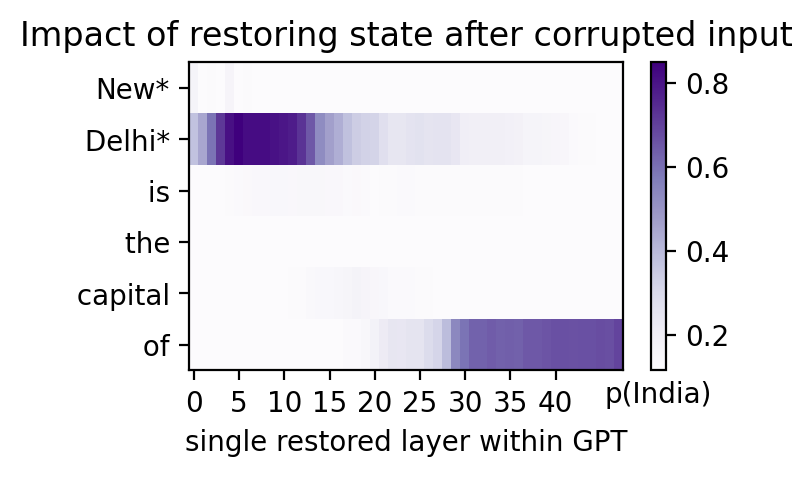

Threshold:  tensor(0.2737)

Highly Activated Neurons:
Layer:  0  Token:  1
Layer:  1  Token:  1
Layer:  2  Token:  1
Layer:  3  Token:  1
Layer:  4  Token:  1
Layer:  5  Token:  1
Layer:  6  Token:  1
Layer:  7  Token:  1
Layer:  8  Token:  1
Layer:  9  Token:  1
Layer:  10  Token:  1
Layer:  11  Token:  1
Layer:  12  Token:  1
Layer:  13  Token:  1
Layer:  14  Token:  1
Layer:  15  Token:  1
Layer:  16  Token:  1
Layer:  17  Token:  1
Layer:  18  Token:  1
Layer:  19  Token:  1



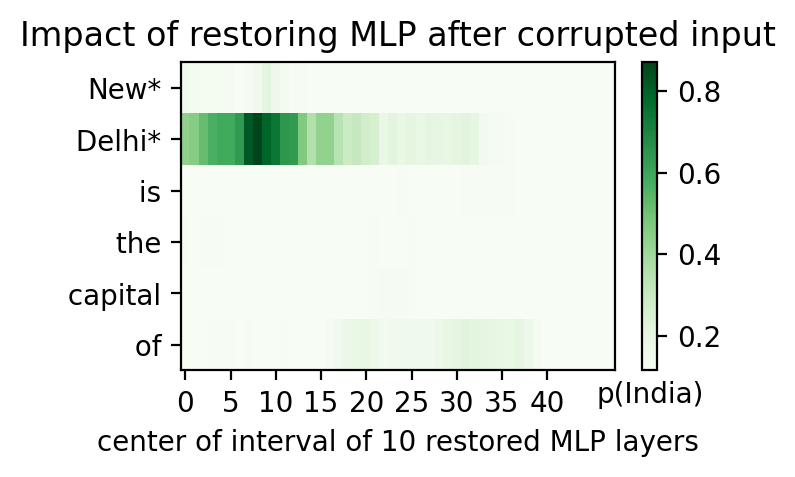

Threshold:  tensor(0.1905)

Highly Activated Neurons:
Layer:  0  Token:  1
Layer:  1  Token:  1
Layer:  2  Token:  1
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  20  Token:  5
Layer:  21  Token:  5
Layer:  22  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5
Layer:  33  Token:  5
Layer:  34  Token:  5



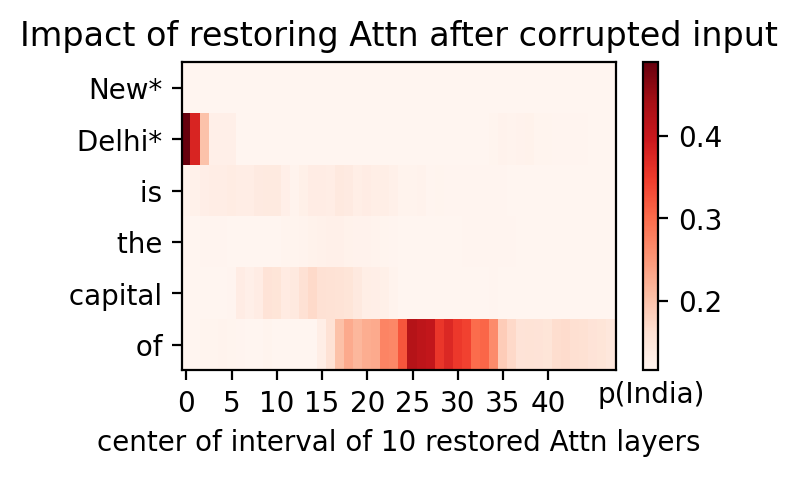

Threshold:  tensor(0.3033)

Highly Activated Neurons:
Layer:  12  Token:  5
Layer:  13  Token:  5
Layer:  14  Token:  5
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  20  Token:  5
Layer:  21  Token:  5
Layer:  22  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5
Layer:  33  Token:  5
Layer:  34  Token:  5
Layer:  35  Token:  5
Layer:  36  Token:  5
Layer:  37  Token:  5
Layer:  38  Token:  5
Layer:  39  Token:  5
Layer:  40  Token:  5
Layer:  41  Token:  5
Layer:  42  Token:  5
Layer:  43  Token:  5
Layer:  44  Token:  5
Layer:  45  Token:  5
Layer:  46  Token:  5
Layer:  47  Token:  5



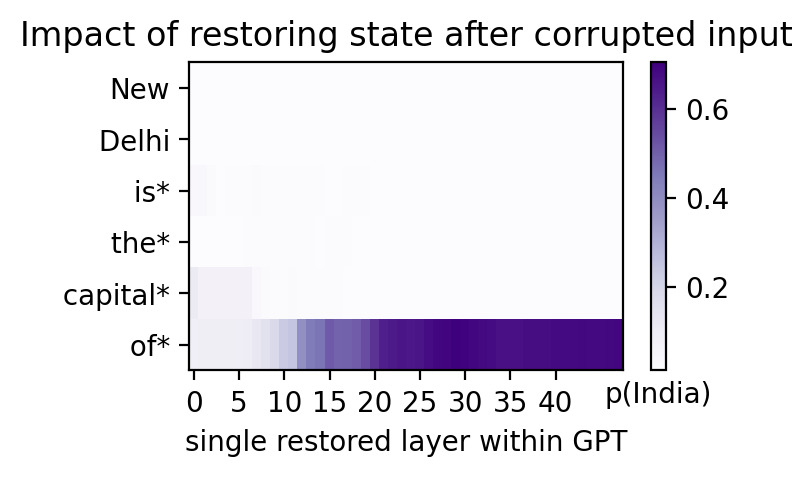

Threshold:  tensor(0.0826)

Highly Activated Neurons:
Layer:  0  Token:  4
Layer:  0  Token:  5
Layer:  1  Token:  5
Layer:  2  Token:  5
Layer:  3  Token:  5
Layer:  5  Token:  5
Layer:  11  Token:  5
Layer:  13  Token:  5
Layer:  14  Token:  5
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  20  Token:  5
Layer:  21  Token:  5
Layer:  22  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5
Layer:  33  Token:  5
Layer:  34  Token:  5



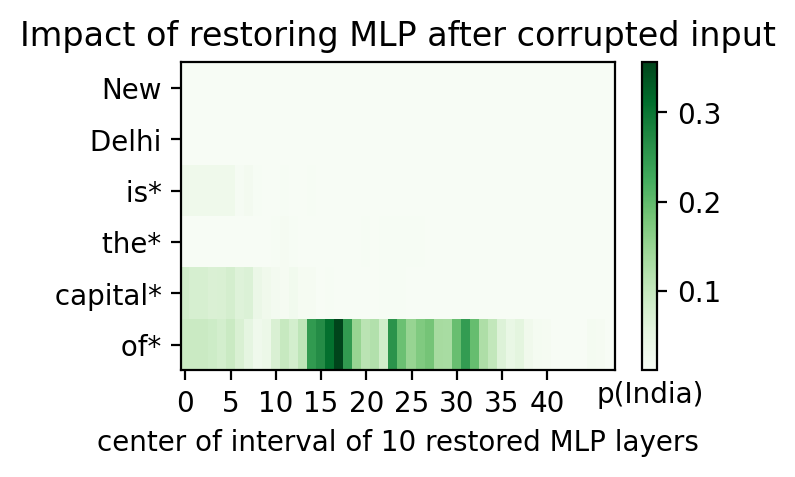

Threshold:  tensor(0.0314)

Highly Activated Neurons:
Layer:  1  Token:  5
Layer:  3  Token:  5
Layer:  4  Token:  5
Layer:  5  Token:  5
Layer:  6  Token:  5
Layer:  7  Token:  5
Layer:  8  Token:  5
Layer:  11  Token:  5
Layer:  12  Token:  5
Layer:  13  Token:  5
Layer:  14  Token:  5
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  20  Token:  5
Layer:  21  Token:  5
Layer:  22  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5



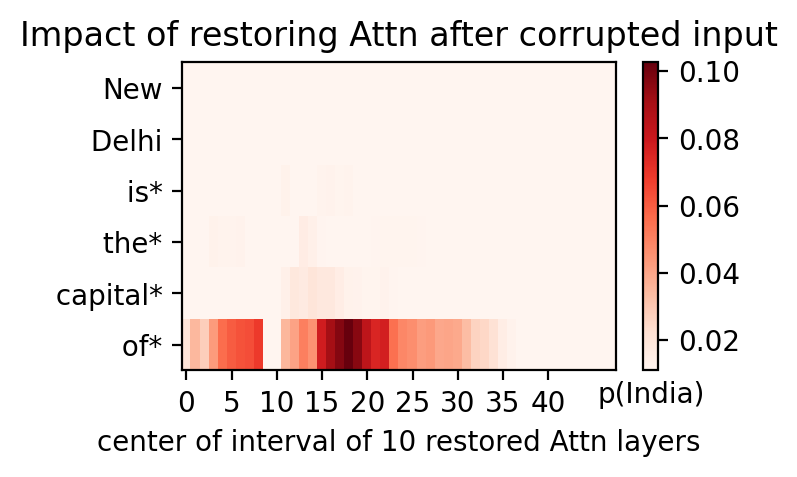

In [ ]:
plot_all_flow(mt, "New Delhi is the capital of", subject = None , noise=noise_level)
plot_all_flow(mt, "New Delhi is the capital of", subject = "is the capital of" , noise=noise_level)

Threshold:  tensor(0.2862)

Highly Activated Neurons:
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5
Layer:  33  Token:  5
Layer:  34  Token:  5
Layer:  35  Token:  5
Layer:  36  Token:  5
Layer:  37  Token:  5
Layer:  38  Token:  5
Layer:  39  Token:  5
Layer:  40  Token:  5
Layer:  41  Token:  5
Layer:  42  Token:  5
Layer:  43  Token:  5
Layer:  44  Token:  5
Layer:  45  Token:  5
Layer:  46  Token:  5
Layer:  47  Token:  5



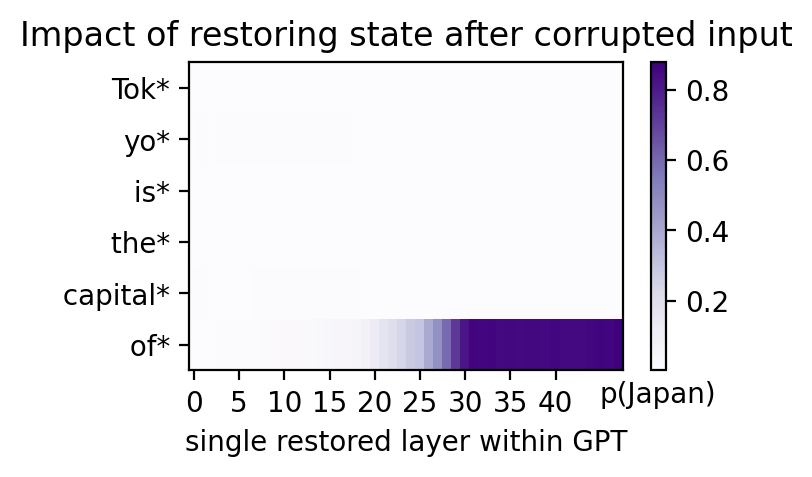

Threshold:  tensor(0.0071)

Highly Activated Neurons:
Layer:  6  Token:  1
Layer:  7  Token:  1
Layer:  10  Token:  1
Layer:  11  Token:  1
Layer:  12  Token:  1
Layer:  13  Token:  1
Layer:  14  Token:  1
Layer:  15  Token:  1
Layer:  16  Token:  1
Layer:  17  Token:  1
Layer:  18  Token:  1
Layer:  19  Token:  1
Layer:  0  Token:  4
Layer:  1  Token:  4
Layer:  2  Token:  4
Layer:  3  Token:  4
Layer:  4  Token:  4
Layer:  5  Token:  4
Layer:  6  Token:  4
Layer:  13  Token:  5
Layer:  14  Token:  5
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5
Layer:  34  Token:  5
Layer:  39  Token:  5
Layer:  40  Token:  5
Layer:  41  Token:  5
Layer:  42  Token:  5
Layer:  43  Token:  5
Layer:  44  Token:  5
Layer:  45  Token:  5
Layer:  46  Token:  5
Layer:  47  Token:  5



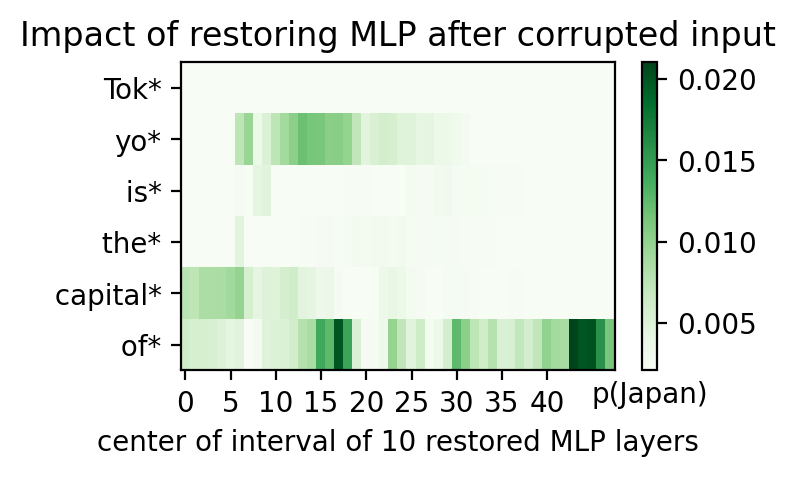

Threshold:  tensor(0.0145)

Highly Activated Neurons:
Layer:  3  Token:  4
Layer:  4  Token:  4
Layer:  7  Token:  4
Layer:  8  Token:  4
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  20  Token:  5
Layer:  21  Token:  5
Layer:  22  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5



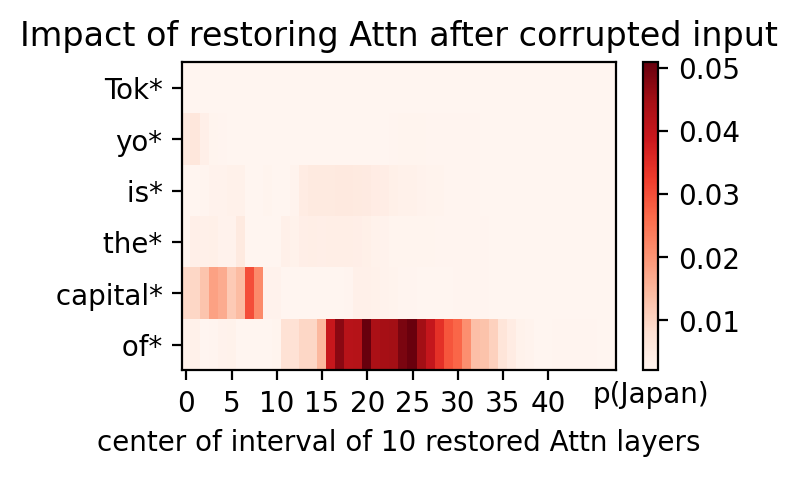

In [ ]:
plot_all_flow(mt, "Tokyo is the capital of", subject = "Tokyo is the capital of" , noise=noise_level)

Threshold:  tensor(0.2501)

Highly Activated Neurons:
Layer:  13  Token:  5
Layer:  14  Token:  5
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  20  Token:  5
Layer:  21  Token:  5
Layer:  22  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5
Layer:  33  Token:  5
Layer:  34  Token:  5
Layer:  35  Token:  5
Layer:  36  Token:  5
Layer:  37  Token:  5
Layer:  38  Token:  5
Layer:  39  Token:  5
Layer:  40  Token:  5
Layer:  41  Token:  5
Layer:  42  Token:  5
Layer:  43  Token:  5
Layer:  44  Token:  5
Layer:  45  Token:  5
Layer:  46  Token:  5
Layer:  47  Token:  5



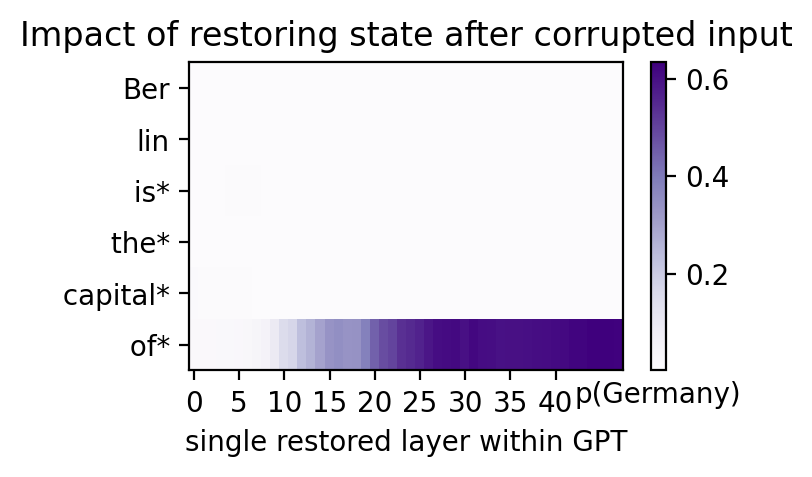

Threshold:  tensor(0.0187)

Highly Activated Neurons:
Layer:  9  Token:  5
Layer:  11  Token:  5
Layer:  12  Token:  5
Layer:  13  Token:  5
Layer:  14  Token:  5
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5
Layer:  33  Token:  5
Layer:  34  Token:  5
Layer:  35  Token:  5
Layer:  36  Token:  5
Layer:  37  Token:  5
Layer:  38  Token:  5



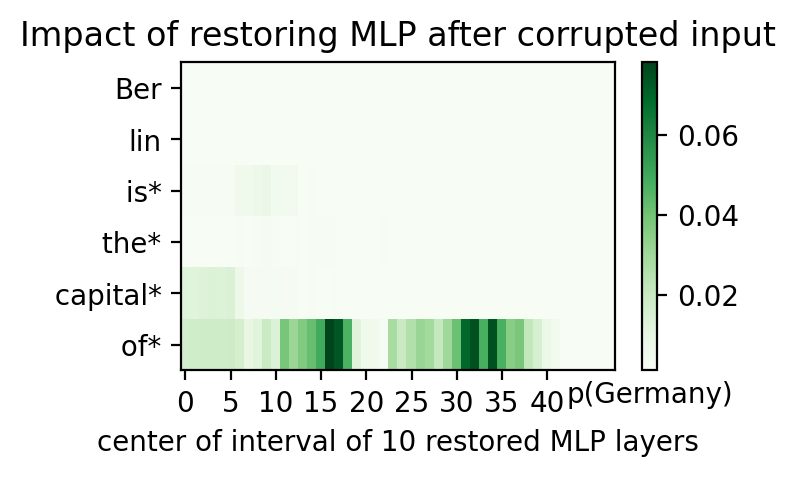

Threshold:  tensor(0.0053)

Highly Activated Neurons:
Layer:  3  Token:  5
Layer:  4  Token:  5
Layer:  5  Token:  5
Layer:  12  Token:  5
Layer:  13  Token:  5
Layer:  14  Token:  5
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  20  Token:  5
Layer:  21  Token:  5
Layer:  22  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5



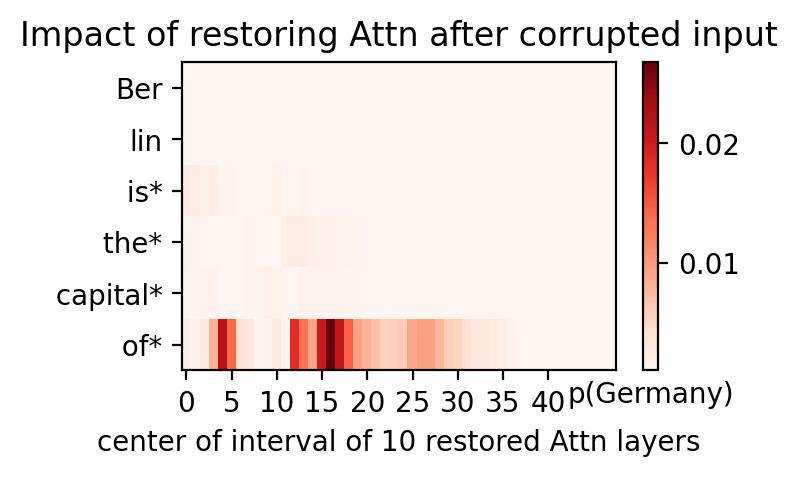

In [ ]:
plot_all_flow(mt, "Berlin is the capital of", subject = "is the capital of", noise=noise_level)

Threshold:  tensor(0.2579)

Highly Activated Neurons:
Layer:  13  Token:  5
Layer:  14  Token:  5
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  20  Token:  5
Layer:  21  Token:  5
Layer:  22  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5
Layer:  33  Token:  5
Layer:  34  Token:  5
Layer:  35  Token:  5
Layer:  36  Token:  5
Layer:  37  Token:  5
Layer:  38  Token:  5
Layer:  39  Token:  5
Layer:  40  Token:  5
Layer:  41  Token:  5
Layer:  42  Token:  5
Layer:  43  Token:  5
Layer:  44  Token:  5
Layer:  45  Token:  5
Layer:  46  Token:  5
Layer:  47  Token:  5



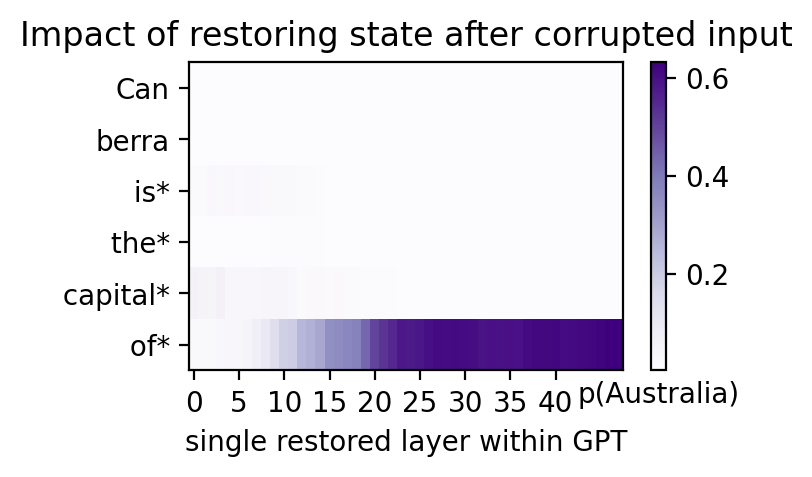

Threshold:  tensor(0.0228)

Highly Activated Neurons:
Layer:  7  Token:  2
Layer:  8  Token:  2
Layer:  9  Token:  2
Layer:  0  Token:  4
Layer:  1  Token:  4
Layer:  2  Token:  4
Layer:  3  Token:  4
Layer:  4  Token:  4
Layer:  5  Token:  4
Layer:  6  Token:  4
Layer:  10  Token:  4
Layer:  9  Token:  5
Layer:  10  Token:  5
Layer:  11  Token:  5
Layer:  12  Token:  5
Layer:  13  Token:  5
Layer:  14  Token:  5
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  22  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  36  Token:  5
Layer:  37  Token:  5
Layer:  38  Token:  5



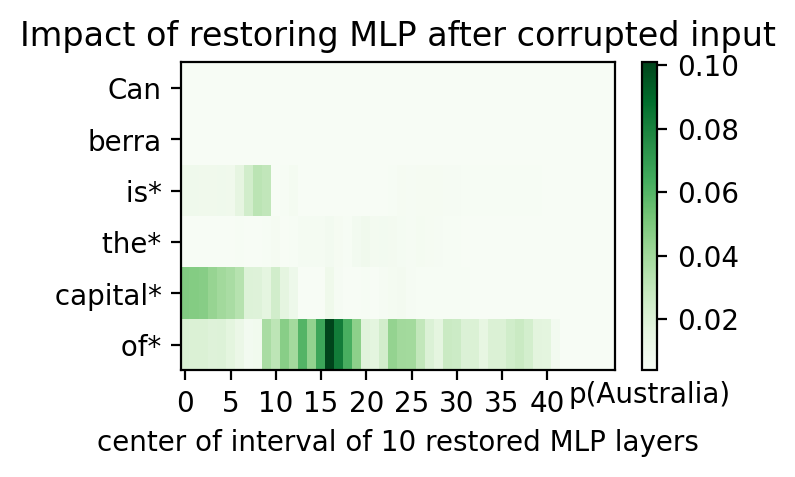

Threshold:  tensor(0.0139)

Highly Activated Neurons:
Layer:  3  Token:  4
Layer:  4  Token:  4
Layer:  5  Token:  4
Layer:  10  Token:  4
Layer:  11  Token:  4
Layer:  12  Token:  4
Layer:  11  Token:  5
Layer:  12  Token:  5
Layer:  13  Token:  5
Layer:  14  Token:  5
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  20  Token:  5
Layer:  21  Token:  5
Layer:  22  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5



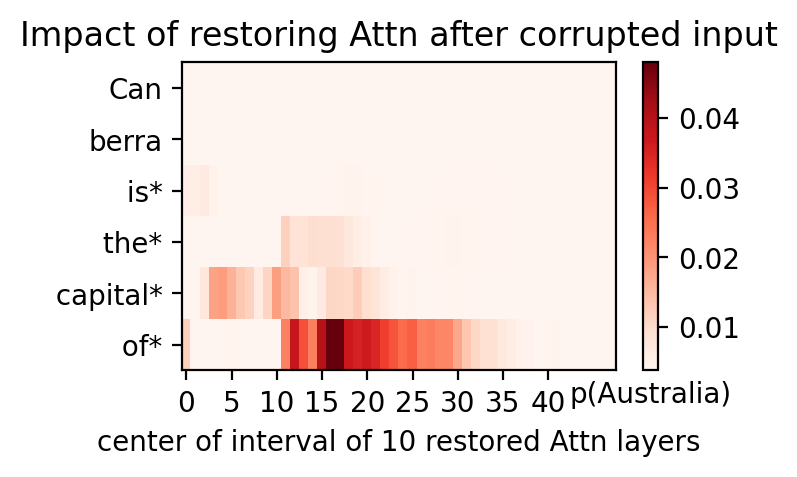

In [ ]:
plot_all_flow(mt, "Canberra is the capital of", subject = "is the capital of", noise=noise_level)

## Relation Plotting

#### Relation Sets

In [ ]:
# -----------------------
# Relation: "is a capital of" (Cities and Countries)

# (Ottawa, is a capital of, Canada)
# (Tokyo, is a capital of, Japan)
# (Canberra, is a capital of, Australia)
# (Berlin, is a capital of, Germany)
# (Nairobi, is a capital of, Kenya)

# -----------------------
# Relation: "are made of" (Materials and Composition)

# (Clothes, are made of, cotton)
# (Cars, are made of, metal)
# (Houses, are made of, wood)
# (Bottles, are made of, glass)
# (Cell phones, are made of, plastic)

# -----------------------
# Relation: "is a" (Famous Individuals and Gender Identity)

# (Serena Williams, is a, woman)
# (Barack Obama,  is a, man)
# (Cristiano Ronaldo, is a, man)
# (Bill Clinton, is a, man)
# (Ratan Tata, is a, man)

# -----------------------
# Relation: "live in the" (Animals and Their Habitation)

# (Bird, live in the, trees)
# (Camels, live in the, desert)
# (Tigers, live in the, forest)
# (Sharks, live in the, ocean)
# (Penguins, live in the, Arctic)

# -----------------------
# Relation: "is headquartered in" (Companies and Their HQ Location)

# (Coca-Cola, is headquartered in, Atlanta)
# (Microsoft, is headquartered in, Redmond)
# (General Motors, is headquartered in, Detroit)
# (Amazon, is headquartered in, Seattle)
# (Berkshire Hathaway, is headquartered in, Omaha)

# -----------------------
# Relation: "are known for their ability to" (Animals and Their Abilities)

# (Cheetahs, are known for their ability to, run)
# (Kangaroos, are known for their ability to, jump)
# (Parrots, are known for their ability to, mimic)
# (Peregrine Falcons, are known for their ability to, fly)
# (Snakes, are known for their ability to, camoflage)

The following prompt can be changed to any factual statement to trace.

### 1. Capitals

Threshold:  tensor(0.4248)

Highly Activated Neurons:
Layer:  1  Token:  1
Layer:  2  Token:  1
Layer:  3  Token:  1
Layer:  4  Token:  1
Layer:  5  Token:  1
Layer:  6  Token:  1
Layer:  7  Token:  1
Layer:  8  Token:  1
Layer:  9  Token:  1
Layer:  10  Token:  1
Layer:  11  Token:  1
Layer:  12  Token:  1
Layer:  13  Token:  1
Layer:  14  Token:  1
Layer:  15  Token:  1
Layer:  16  Token:  1
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5
Layer:  33  Token:  5
Layer:  34  Token:  5
Layer:  35  Token:  5
Layer:  36  Token:  5
Layer:  37  Token:  5
Layer:  38  Token:  5
Layer:  39  Token:  5
Layer:  40  Token:  5
Layer:  41  Token:  5
Layer:  42  Token:  5
Layer:  43  Token:  5
Layer:  44  Token:  5
Layer:  45  Token:  5
Layer:  46  Token:  5
Layer:  47  Token:  5



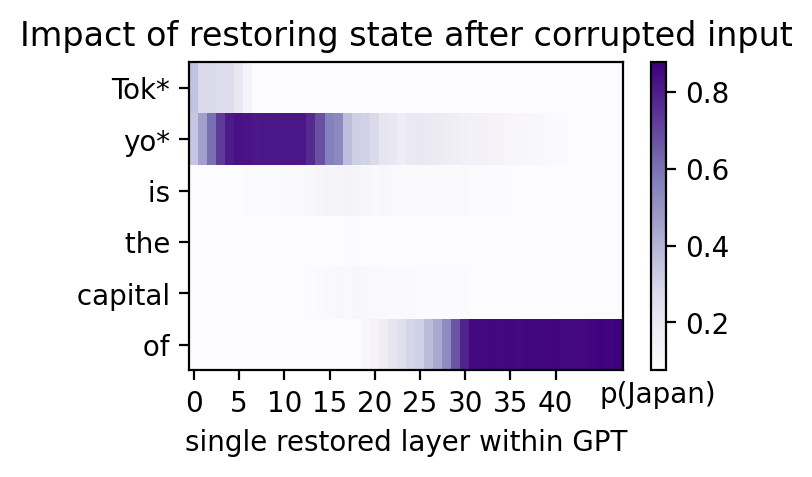

Threshold:  tensor(0.2742)

Highly Activated Neurons:
Layer:  0  Token:  0
Layer:  1  Token:  0
Layer:  2  Token:  0
Layer:  3  Token:  0
Layer:  4  Token:  0
Layer:  5  Token:  0
Layer:  0  Token:  1
Layer:  1  Token:  1
Layer:  2  Token:  1
Layer:  3  Token:  1
Layer:  4  Token:  1
Layer:  5  Token:  1
Layer:  6  Token:  1
Layer:  7  Token:  1
Layer:  8  Token:  1
Layer:  9  Token:  1
Layer:  10  Token:  1
Layer:  11  Token:  1
Layer:  12  Token:  1
Layer:  13  Token:  1
Layer:  14  Token:  1
Layer:  15  Token:  1
Layer:  16  Token:  1
Layer:  17  Token:  1
Layer:  18  Token:  1
Layer:  19  Token:  1



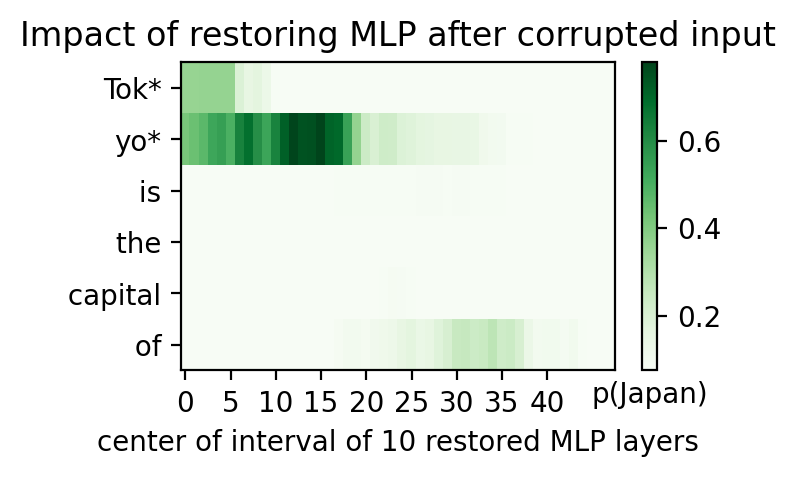

Threshold:  tensor(0.1988)

Highly Activated Neurons:
Layer:  0  Token:  1
Layer:  1  Token:  1
Layer:  2  Token:  1
Layer:  3  Token:  1
Layer:  4  Token:  1
Layer:  5  Token:  1
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  20  Token:  5
Layer:  21  Token:  5
Layer:  22  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5
Layer:  33  Token:  5
Layer:  34  Token:  5
Layer:  35  Token:  5



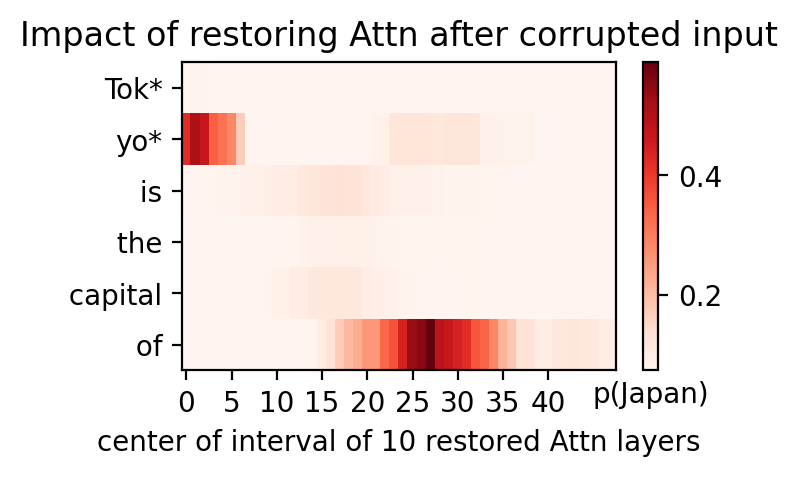

In [ ]:
plot_all_flow(mt, "Tokyo is the capital of", noise=noise_level)

Threshold:  tensor(0.2752)

Highly Activated Neurons:
Layer:  0  Token:  4
Layer:  1  Token:  4
Layer:  2  Token:  4
Layer:  3  Token:  4
Layer:  4  Token:  4
Layer:  5  Token:  4
Layer:  6  Token:  4
Layer:  7  Token:  4
Layer:  8  Token:  4
Layer:  9  Token:  4
Layer:  10  Token:  4
Layer:  14  Token:  5
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  20  Token:  5
Layer:  21  Token:  5
Layer:  22  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5
Layer:  33  Token:  5
Layer:  34  Token:  5
Layer:  35  Token:  5
Layer:  36  Token:  5
Layer:  37  Token:  5
Layer:  38  Token:  5
Layer:  39  Token:  5
Layer:  40  Token:  5
Layer:  41  Token:  5
Layer:  42  Token:  5
Layer:  43  Token:  5
Layer:  44  Token:  5
Layer:  45  Token:  5
Layer:  46

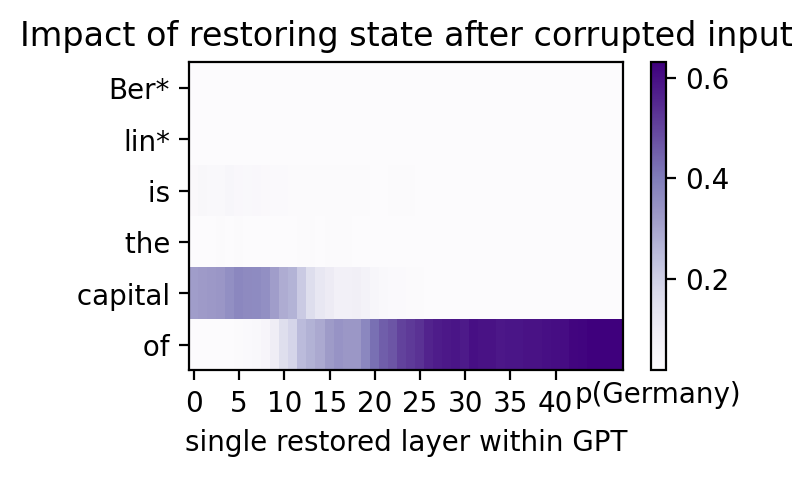

Threshold:  tensor(0.0890)

Highly Activated Neurons:
Layer:  0  Token:  4
Layer:  1  Token:  4
Layer:  2  Token:  4
Layer:  3  Token:  4
Layer:  4  Token:  4
Layer:  5  Token:  4
Layer:  6  Token:  4
Layer:  7  Token:  4
Layer:  8  Token:  4
Layer:  9  Token:  4
Layer:  10  Token:  4
Layer:  11  Token:  4
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  25  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5
Layer:  34  Token:  5



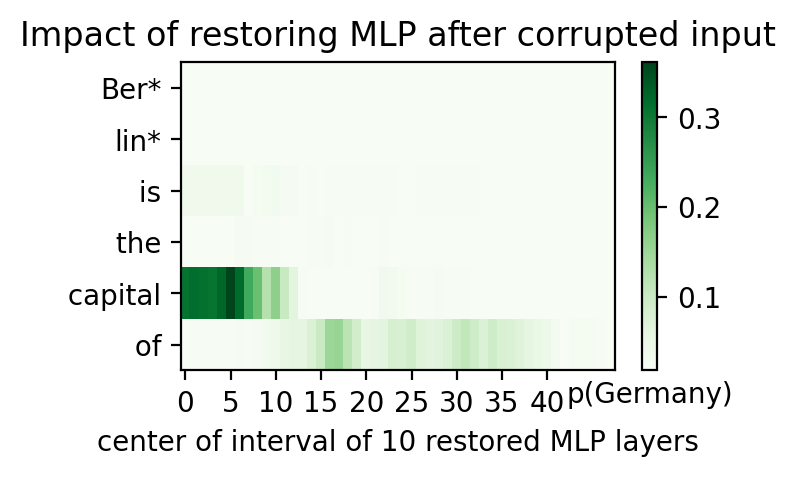

Threshold:  tensor(0.1118)

Highly Activated Neurons:
Layer:  6  Token:  5
Layer:  7  Token:  5
Layer:  8  Token:  5
Layer:  9  Token:  5
Layer:  10  Token:  5
Layer:  11  Token:  5
Layer:  12  Token:  5
Layer:  13  Token:  5
Layer:  14  Token:  5
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  20  Token:  5
Layer:  21  Token:  5
Layer:  22  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5



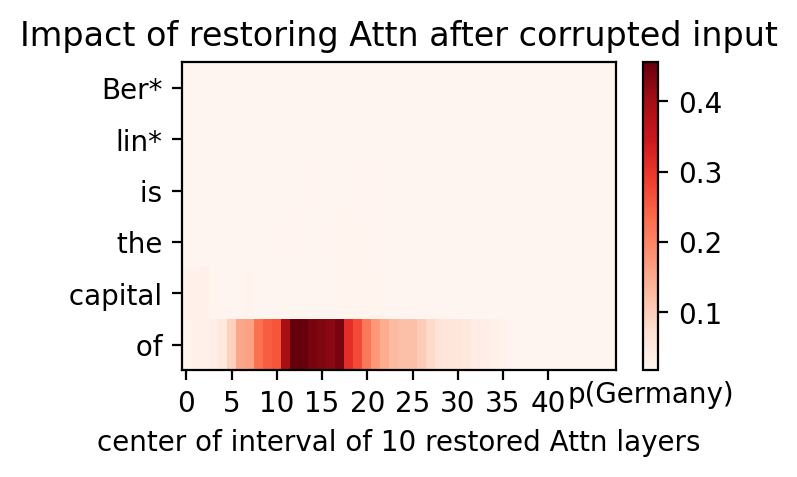

In [ ]:
plot_all_flow(mt, "Berlin is the capital of", noise=noise_level)

Threshold:  tensor(0.2976)

Highly Activated Neurons:
Layer:  3  Token:  4
Layer:  4  Token:  4
Layer:  5  Token:  4
Layer:  6  Token:  4
Layer:  7  Token:  4
Layer:  8  Token:  4
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  20  Token:  5
Layer:  21  Token:  5
Layer:  22  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5
Layer:  28  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  32  Token:  5
Layer:  33  Token:  5
Layer:  34  Token:  5
Layer:  35  Token:  5
Layer:  36  Token:  5
Layer:  37  Token:  5
Layer:  38  Token:  5
Layer:  39  Token:  5
Layer:  40  Token:  5
Layer:  41  Token:  5
Layer:  42  Token:  5
Layer:  43  Token:  5
Layer:  44  Token:  5
Layer:  45  Token:  5
Layer:  46  Token:  5
Layer:  47  Token:  5



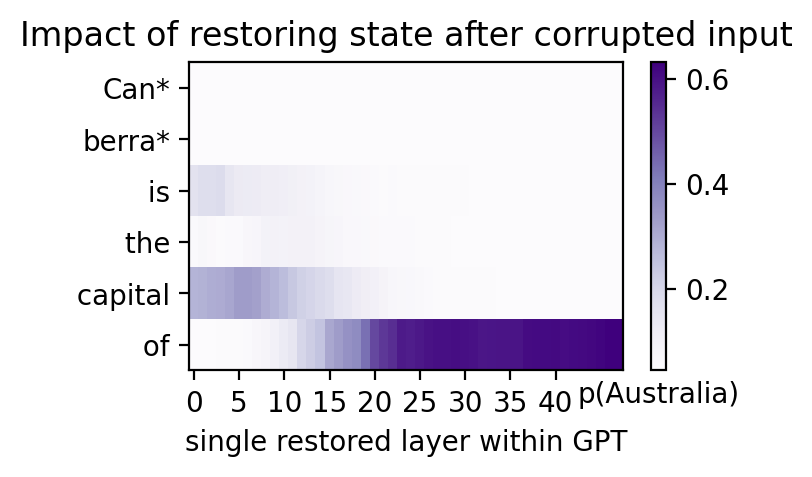

Threshold:  tensor(0.1084)

Highly Activated Neurons:
Layer:  0  Token:  2
Layer:  1  Token:  2
Layer:  2  Token:  2
Layer:  3  Token:  2
Layer:  4  Token:  2
Layer:  5  Token:  2
Layer:  6  Token:  2
Layer:  7  Token:  2
Layer:  0  Token:  4
Layer:  1  Token:  4
Layer:  2  Token:  4
Layer:  3  Token:  4
Layer:  4  Token:  4
Layer:  5  Token:  4
Layer:  6  Token:  4
Layer:  7  Token:  4
Layer:  8  Token:  4
Layer:  9  Token:  4
Layer:  10  Token:  4
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  29  Token:  5
Layer:  30  Token:  5
Layer:  31  Token:  5
Layer:  34  Token:  5
Layer:  35  Token:  5
Layer:  36  Token:  5
Layer:  37  Token:  5



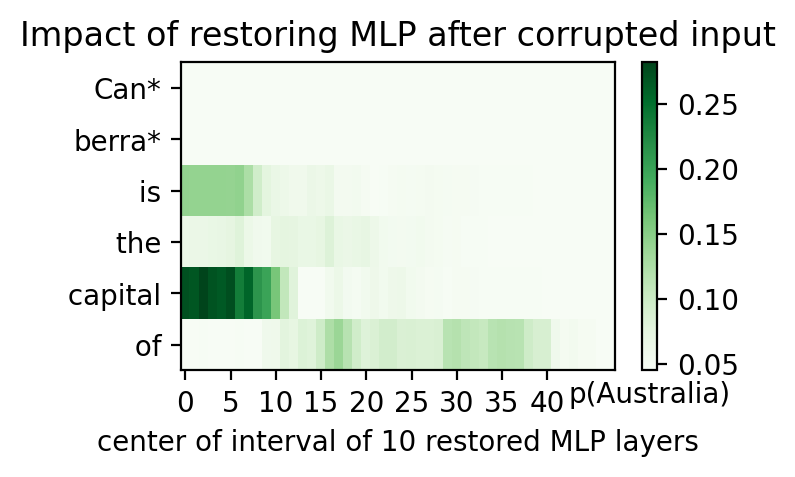

Threshold:  tensor(0.1454)

Highly Activated Neurons:
Layer:  8  Token:  5
Layer:  9  Token:  5
Layer:  10  Token:  5
Layer:  11  Token:  5
Layer:  12  Token:  5
Layer:  13  Token:  5
Layer:  14  Token:  5
Layer:  15  Token:  5
Layer:  16  Token:  5
Layer:  17  Token:  5
Layer:  18  Token:  5
Layer:  19  Token:  5
Layer:  20  Token:  5
Layer:  21  Token:  5
Layer:  22  Token:  5
Layer:  23  Token:  5
Layer:  24  Token:  5
Layer:  25  Token:  5
Layer:  26  Token:  5
Layer:  27  Token:  5



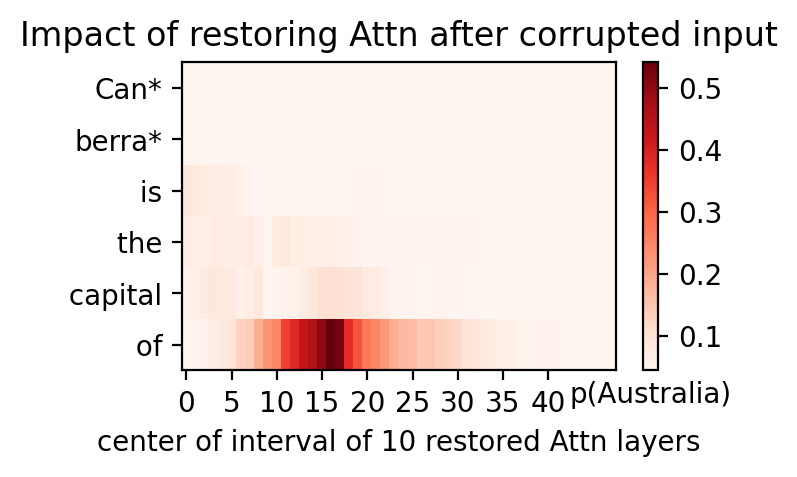

In [ ]:
plot_all_flow(mt, "Canberra is the capital of", noise=noise_level)

### 2. Companies & HQs

Threshold:  tensor(0.4476)

Highly Activated Neurons:
Layer:  0  Token:  5
Layer:  1  Token:  5
Layer:  2  Token:  5
Layer:  3  Token:  5
Layer:  4  Token:  5
Layer:  5  Token:  5
Layer:  6  Token:  5
Layer:  7  Token:  5
Layer:  8  Token:  5
Layer:  9  Token:  5
Layer:  10  Token:  5
Layer:  11  Token:  5
Layer:  12  Token:  5
Layer:  13  Token:  5
Layer:  14  Token:  5
Layer:  12  Token:  6
Layer:  13  Token:  6
Layer:  14  Token:  6
Layer:  15  Token:  6
Layer:  16  Token:  6
Layer:  17  Token:  6
Layer:  18  Token:  6
Layer:  19  Token:  6
Layer:  20  Token:  6
Layer:  21  Token:  6
Layer:  22  Token:  6
Layer:  23  Token:  6
Layer:  24  Token:  6
Layer:  25  Token:  6
Layer:  26  Token:  6
Layer:  27  Token:  6
Layer:  28  Token:  6
Layer:  29  Token:  6
Layer:  30  Token:  6
Layer:  31  Token:  6
Layer:  32  Token:  6
Layer:  33  Token:  6
Layer:  34  Token:  6
Layer:  35  Token:  6
Layer:  36  Token:  6
Layer:  37  Token:  6
Layer:  38  Token:  6
Layer:  39  Token:  6
Layer:  40

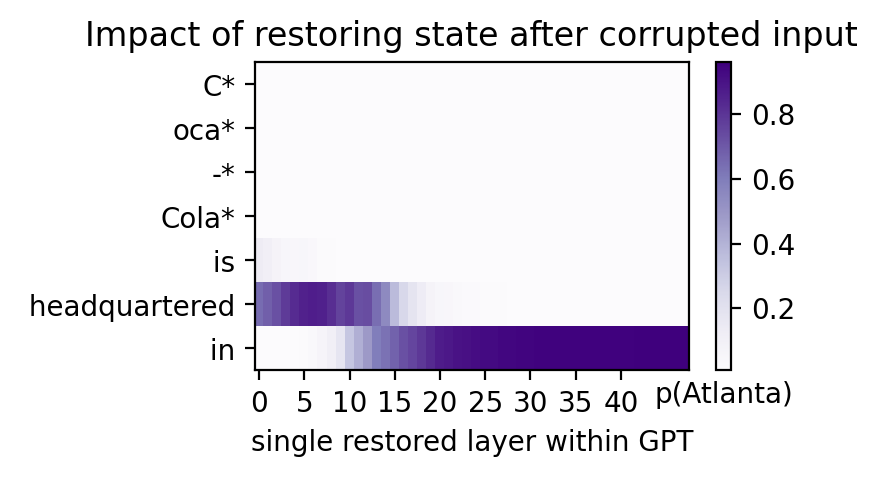

Threshold:  tensor(0.1352)

Highly Activated Neurons:
Layer:  0  Token:  4
Layer:  1  Token:  4
Layer:  2  Token:  4
Layer:  3  Token:  4
Layer:  4  Token:  4
Layer:  5  Token:  4
Layer:  0  Token:  5
Layer:  1  Token:  5
Layer:  2  Token:  5
Layer:  3  Token:  5
Layer:  4  Token:  5
Layer:  5  Token:  5
Layer:  6  Token:  5
Layer:  7  Token:  5
Layer:  8  Token:  5
Layer:  9  Token:  5
Layer:  10  Token:  5
Layer:  11  Token:  5
Layer:  18  Token:  5



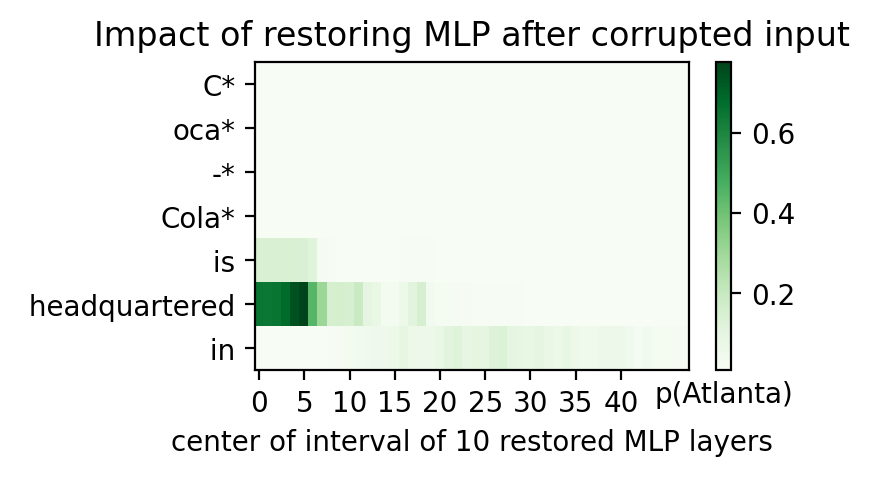

Threshold:  tensor(0.1338)

Highly Activated Neurons:
Layer:  5  Token:  6
Layer:  6  Token:  6
Layer:  7  Token:  6
Layer:  8  Token:  6
Layer:  9  Token:  6
Layer:  10  Token:  6
Layer:  11  Token:  6
Layer:  12  Token:  6
Layer:  13  Token:  6
Layer:  14  Token:  6
Layer:  15  Token:  6
Layer:  16  Token:  6
Layer:  17  Token:  6
Layer:  18  Token:  6
Layer:  19  Token:  6
Layer:  20  Token:  6
Layer:  21  Token:  6



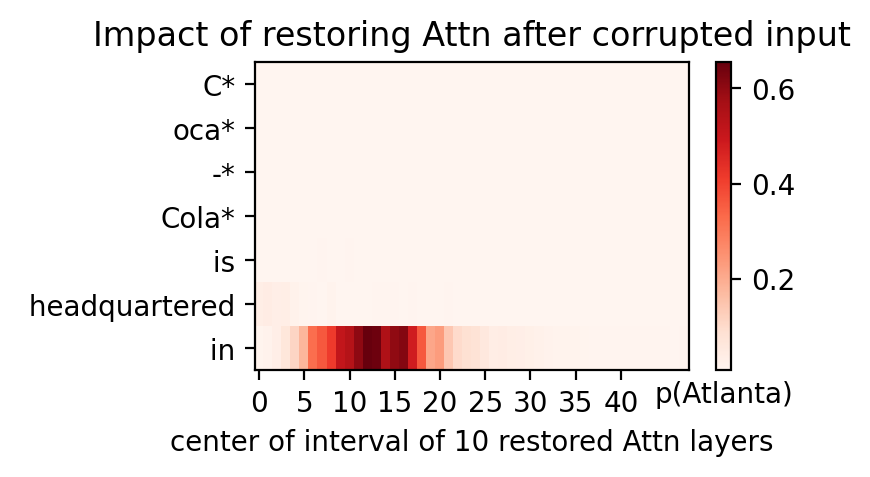

In [ ]:
plot_all_flow(mt, "Coca-Cola is headquartered in", noise=noise_level)

Threshold:  tensor(0.4007)

Highly Activated Neurons:
Layer:  29  Token:  3
Layer:  30  Token:  3
Layer:  31  Token:  3
Layer:  32  Token:  3
Layer:  33  Token:  3
Layer:  34  Token:  3
Layer:  35  Token:  3
Layer:  36  Token:  3
Layer:  37  Token:  3
Layer:  38  Token:  3
Layer:  39  Token:  3
Layer:  40  Token:  3
Layer:  41  Token:  3
Layer:  42  Token:  3
Layer:  43  Token:  3
Layer:  44  Token:  3
Layer:  45  Token:  3
Layer:  46  Token:  3
Layer:  47  Token:  3



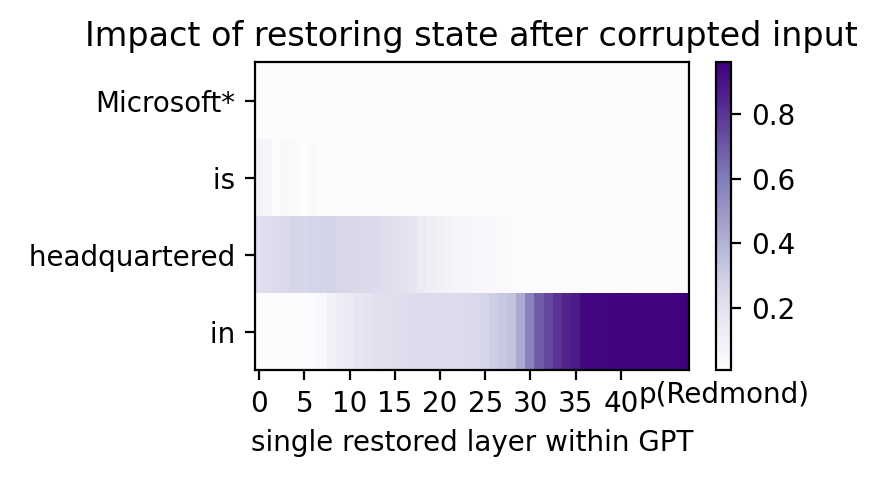

Threshold:  tensor(0.0877)

Highly Activated Neurons:
Layer:  6  Token:  1
Layer:  0  Token:  2
Layer:  1  Token:  2
Layer:  2  Token:  2
Layer:  3  Token:  2
Layer:  4  Token:  2
Layer:  5  Token:  2
Layer:  6  Token:  2
Layer:  7  Token:  2
Layer:  8  Token:  2
Layer:  9  Token:  2
Layer:  10  Token:  2
Layer:  11  Token:  2
Layer:  12  Token:  2
Layer:  18  Token:  2
Layer:  16  Token:  3
Layer:  17  Token:  3
Layer:  19  Token:  3
Layer:  20  Token:  3
Layer:  21  Token:  3
Layer:  22  Token:  3
Layer:  23  Token:  3
Layer:  24  Token:  3



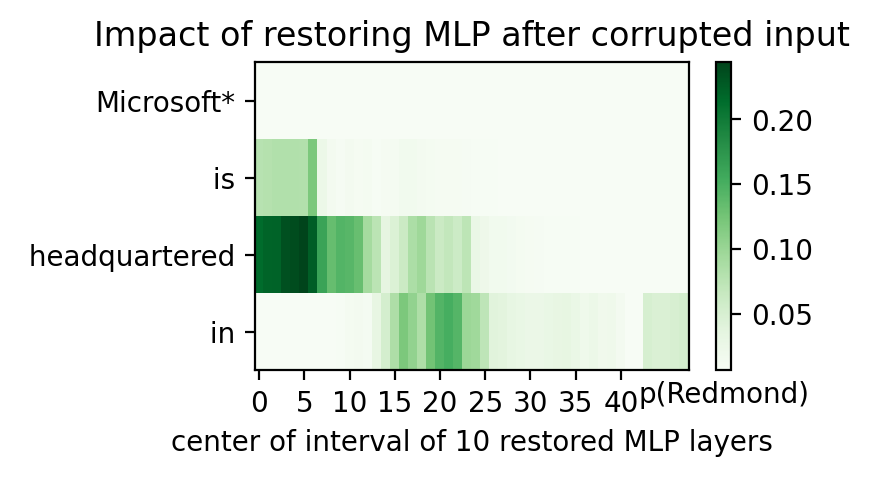

Threshold:  tensor(0.0841)

Highly Activated Neurons:
Layer:  0  Token:  2
Layer:  1  Token:  2
Layer:  2  Token:  2
Layer:  4  Token:  3
Layer:  5  Token:  3
Layer:  6  Token:  3
Layer:  7  Token:  3
Layer:  8  Token:  3
Layer:  9  Token:  3
Layer:  10  Token:  3
Layer:  11  Token:  3
Layer:  12  Token:  3
Layer:  13  Token:  3
Layer:  14  Token:  3
Layer:  15  Token:  3
Layer:  16  Token:  3
Layer:  17  Token:  3
Layer:  18  Token:  3
Layer:  19  Token:  3
Layer:  20  Token:  3
Layer:  21  Token:  3
Layer:  22  Token:  3
Layer:  23  Token:  3
Layer:  24  Token:  3



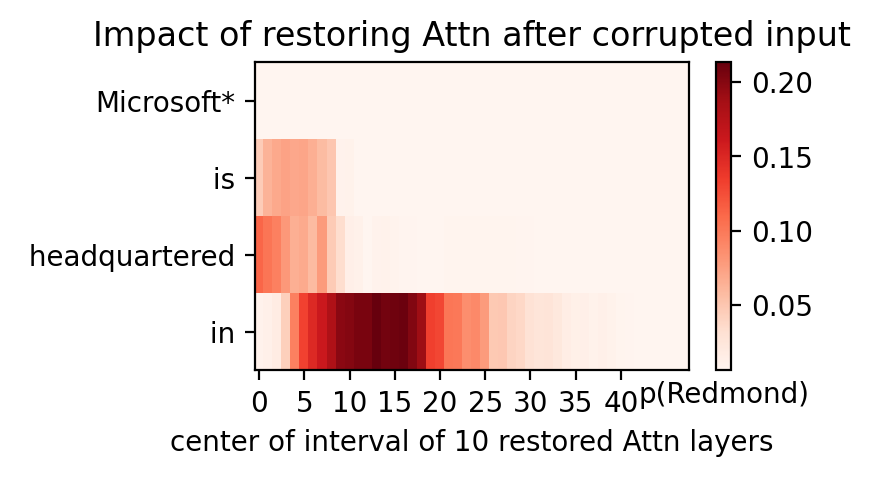

In [ ]:
plot_all_flow(mt, "Microsoft is headquartered in", noise=noise_level)

Threshold:  tensor(0.4680)

Highly Activated Neurons:
Layer:  0  Token:  6
Layer:  1  Token:  6
Layer:  2  Token:  6
Layer:  3  Token:  6
Layer:  4  Token:  6
Layer:  5  Token:  6
Layer:  6  Token:  6
Layer:  7  Token:  6
Layer:  8  Token:  6
Layer:  9  Token:  6
Layer:  10  Token:  6
Layer:  11  Token:  6
Layer:  12  Token:  6
Layer:  13  Token:  6
Layer:  14  Token:  6
Layer:  15  Token:  6
Layer:  16  Token:  6
Layer:  17  Token:  6
Layer:  18  Token:  6
Layer:  9  Token:  7
Layer:  10  Token:  7
Layer:  11  Token:  7
Layer:  12  Token:  7
Layer:  13  Token:  7
Layer:  14  Token:  7
Layer:  15  Token:  7
Layer:  16  Token:  7
Layer:  17  Token:  7
Layer:  18  Token:  7
Layer:  19  Token:  7
Layer:  20  Token:  7
Layer:  21  Token:  7
Layer:  22  Token:  7
Layer:  23  Token:  7
Layer:  24  Token:  7
Layer:  25  Token:  7
Layer:  26  Token:  7
Layer:  27  Token:  7
Layer:  28  Token:  7
Layer:  29  Token:  7
Layer:  30  Token:  7
Layer:  31  Token:  7
Layer:  32  Token:  7
Layer:  33 

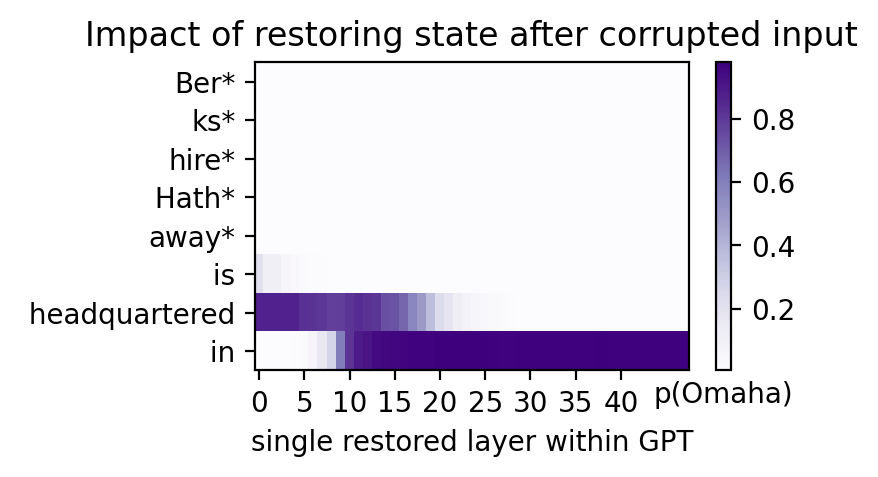

Threshold:  tensor(0.1947)

Highly Activated Neurons:
Layer:  0  Token:  6
Layer:  1  Token:  6
Layer:  2  Token:  6
Layer:  3  Token:  6
Layer:  4  Token:  6
Layer:  5  Token:  6
Layer:  6  Token:  6
Layer:  7  Token:  6
Layer:  8  Token:  6
Layer:  9  Token:  6
Layer:  10  Token:  6
Layer:  11  Token:  6
Layer:  12  Token:  6
Layer:  13  Token:  6
Layer:  14  Token:  6
Layer:  16  Token:  6
Layer:  17  Token:  6
Layer:  21  Token:  7
Layer:  22  Token:  7
Layer:  23  Token:  7
Layer:  24  Token:  7
Layer:  25  Token:  7
Layer:  26  Token:  7
Layer:  27  Token:  7
Layer:  28  Token:  7
Layer:  29  Token:  7
Layer:  30  Token:  7
Layer:  31  Token:  7
Layer:  36  Token:  7
Layer:  43  Token:  7



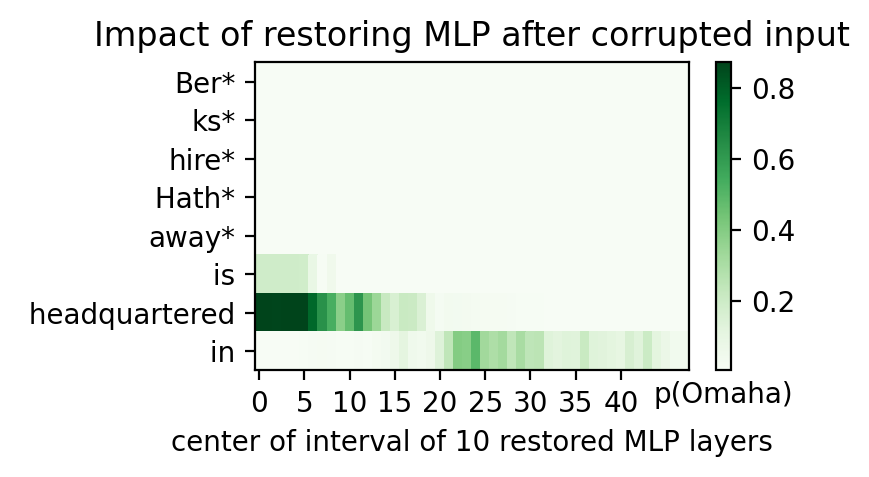

Threshold:  tensor(0.2095)

Highly Activated Neurons:
Layer:  3  Token:  6
Layer:  4  Token:  6
Layer:  5  Token:  6
Layer:  4  Token:  7
Layer:  5  Token:  7
Layer:  6  Token:  7
Layer:  7  Token:  7
Layer:  8  Token:  7
Layer:  9  Token:  7
Layer:  10  Token:  7
Layer:  11  Token:  7
Layer:  12  Token:  7
Layer:  13  Token:  7
Layer:  14  Token:  7
Layer:  15  Token:  7
Layer:  16  Token:  7
Layer:  17  Token:  7
Layer:  18  Token:  7
Layer:  19  Token:  7
Layer:  20  Token:  7
Layer:  21  Token:  7
Layer:  22  Token:  7
Layer:  23  Token:  7
Layer:  24  Token:  7



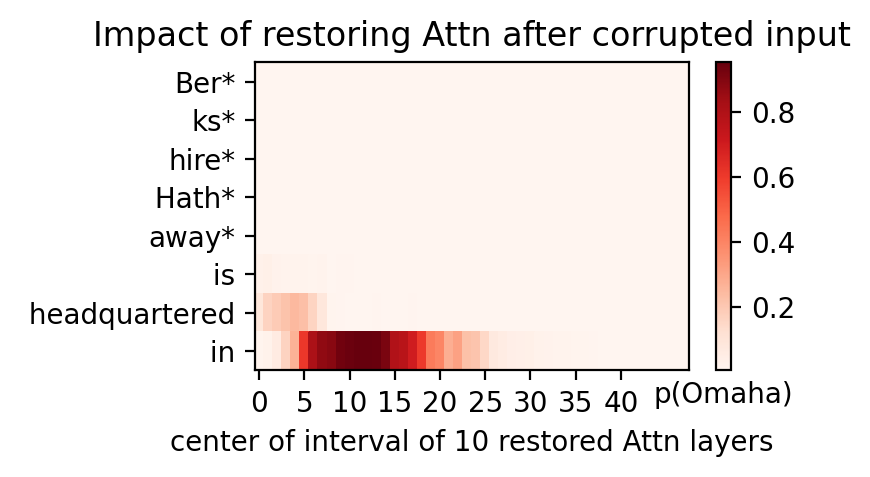

In [ ]:
plot_all_flow(mt, "Berkshire Hathaway is headquartered in", noise=noise_level)

### 3. Animals & Abilities

Threshold:  tensor(0.0223)

Highly Activated Neurons:
Layer:  8  Token:  3
Layer:  9  Token:  3
Layer:  10  Token:  3
Layer:  11  Token:  3
Layer:  12  Token:  3
Layer:  13  Token:  3
Layer:  14  Token:  3
Layer:  15  Token:  3
Layer:  16  Token:  3
Layer:  17  Token:  3
Layer:  18  Token:  3
Layer:  25  Token:  9
Layer:  26  Token:  9
Layer:  27  Token:  9
Layer:  28  Token:  9
Layer:  29  Token:  9
Layer:  30  Token:  9
Layer:  31  Token:  9
Layer:  32  Token:  9
Layer:  33  Token:  9
Layer:  34  Token:  9
Layer:  35  Token:  9
Layer:  36  Token:  9
Layer:  37  Token:  9
Layer:  38  Token:  9
Layer:  39  Token:  9
Layer:  40  Token:  9
Layer:  41  Token:  9
Layer:  42  Token:  9
Layer:  43  Token:  9
Layer:  44  Token:  9
Layer:  45  Token:  9
Layer:  46  Token:  9
Layer:  47  Token:  9



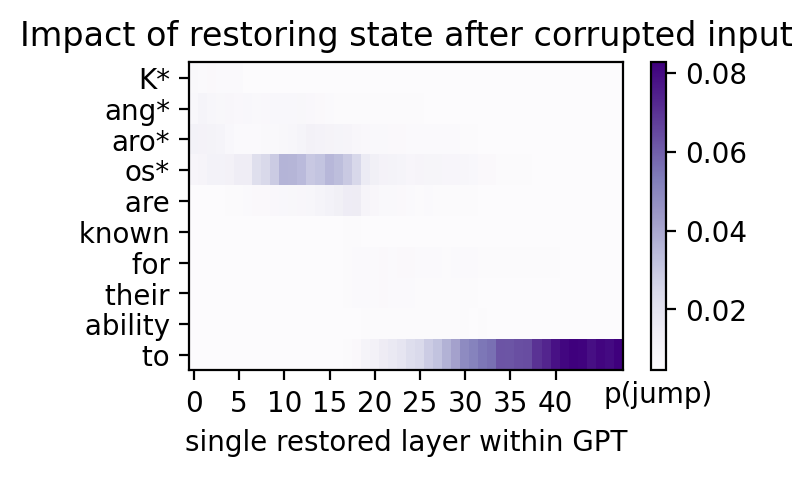

Threshold:  tensor(0.0092)

Highly Activated Neurons:
Layer:  6  Token:  1
Layer:  7  Token:  1
Layer:  8  Token:  1
Layer:  9  Token:  1
Layer:  10  Token:  1
Layer:  11  Token:  1
Layer:  12  Token:  1
Layer:  13  Token:  1
Layer:  0  Token:  2
Layer:  1  Token:  2
Layer:  2  Token:  2
Layer:  3  Token:  2
Layer:  4  Token:  2
Layer:  5  Token:  2
Layer:  6  Token:  2
Layer:  18  Token:  2
Layer:  19  Token:  2
Layer:  20  Token:  2
Layer:  1  Token:  3
Layer:  2  Token:  3
Layer:  3  Token:  3
Layer:  4  Token:  3
Layer:  10  Token:  3
Layer:  11  Token:  3
Layer:  12  Token:  3
Layer:  13  Token:  3
Layer:  14  Token:  3
Layer:  15  Token:  3
Layer:  16  Token:  3
Layer:  17  Token:  3
Layer:  18  Token:  3
Layer:  19  Token:  3
Layer:  20  Token:  3
Layer:  30  Token:  9
Layer:  31  Token:  9
Layer:  32  Token:  9
Layer:  33  Token:  9
Layer:  34  Token:  9
Layer:  35  Token:  9
Layer:  36  Token:  9
Layer:  37  Token:  9
Layer:  38  Token:  9
Layer:  39  Token:  9
Layer:  40  Tok

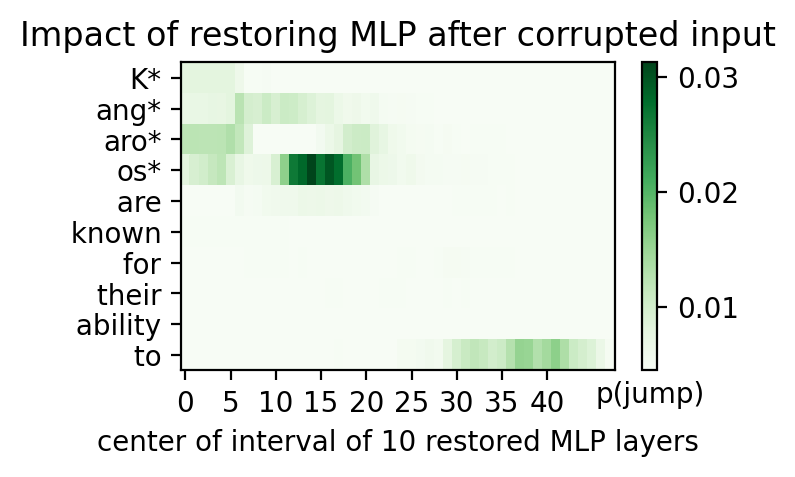

Threshold:  tensor(0.0100)

Highly Activated Neurons:
Layer:  9  Token:  3
Layer:  10  Token:  3
Layer:  11  Token:  3
Layer:  12  Token:  3
Layer:  13  Token:  3
Layer:  14  Token:  3
Layer:  15  Token:  3
Layer:  16  Token:  3
Layer:  12  Token:  4
Layer:  13  Token:  4
Layer:  14  Token:  4
Layer:  15  Token:  4
Layer:  16  Token:  4
Layer:  17  Token:  4
Layer:  18  Token:  4
Layer:  19  Token:  4
Layer:  20  Token:  4
Layer:  21  Token:  4
Layer:  22  Token:  4
Layer:  16  Token:  9
Layer:  17  Token:  9
Layer:  18  Token:  9
Layer:  19  Token:  9
Layer:  20  Token:  9
Layer:  21  Token:  9
Layer:  22  Token:  9
Layer:  23  Token:  9
Layer:  24  Token:  9
Layer:  25  Token:  9
Layer:  26  Token:  9
Layer:  27  Token:  9
Layer:  28  Token:  9
Layer:  29  Token:  9
Layer:  30  Token:  9
Layer:  31  Token:  9
Layer:  32  Token:  9
Layer:  33  Token:  9
Layer:  34  Token:  9
Layer:  35  Token:  9
Layer:  36  Token:  9
Layer:  37  Token:  9
Layer:  39  Token:  9



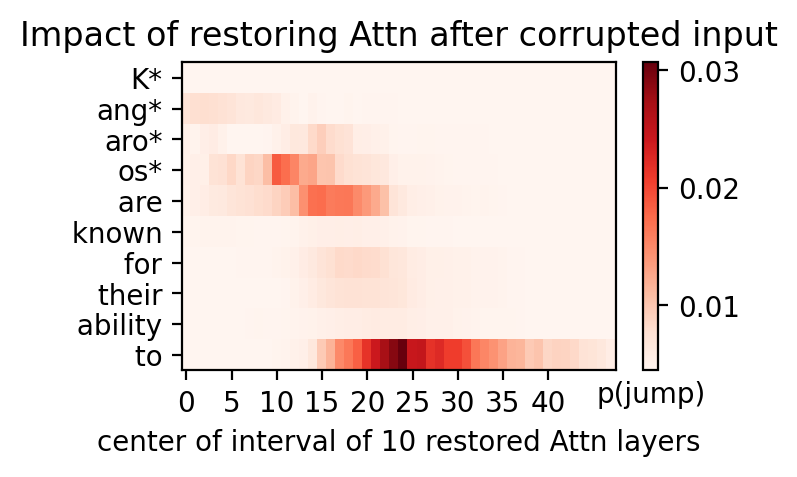

In [ ]:
plot_all_flow(mt, "Kangaroos are known for their ability to", noise=noise_level)

Threshold:  tensor(0.0899)

Highly Activated Neurons:
Layer:  0  Token:  1
Layer:  1  Token:  1
Layer:  2  Token:  1
Layer:  3  Token:  1
Layer:  4  Token:  1
Layer:  5  Token:  1
Layer:  6  Token:  1
Layer:  7  Token:  1
Layer:  8  Token:  1
Layer:  9  Token:  1
Layer:  10  Token:  1
Layer:  11  Token:  1
Layer:  12  Token:  1
Layer:  13  Token:  1
Layer:  14  Token:  1
Layer:  15  Token:  1
Layer:  16  Token:  1
Layer:  17  Token:  1
Layer:  18  Token:  1
Layer:  19  Token:  1
Layer:  31  Token:  7
Layer:  32  Token:  7
Layer:  33  Token:  7
Layer:  34  Token:  7
Layer:  35  Token:  7
Layer:  36  Token:  7
Layer:  37  Token:  7
Layer:  38  Token:  7
Layer:  39  Token:  7
Layer:  40  Token:  7
Layer:  41  Token:  7
Layer:  42  Token:  7
Layer:  43  Token:  7
Layer:  44  Token:  7
Layer:  45  Token:  7
Layer:  46  Token:  7
Layer:  47  Token:  7



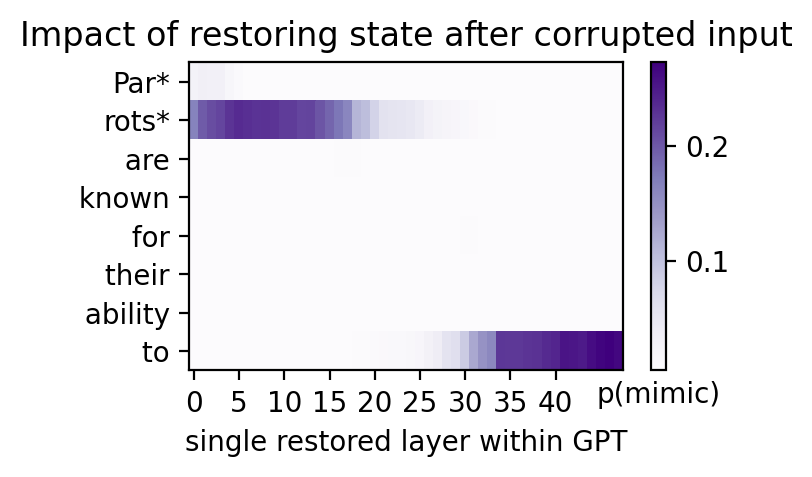

Threshold:  tensor(0.0468)

Highly Activated Neurons:
Layer:  0  Token:  1
Layer:  1  Token:  1
Layer:  2  Token:  1
Layer:  3  Token:  1
Layer:  4  Token:  1
Layer:  5  Token:  1
Layer:  6  Token:  1
Layer:  7  Token:  1
Layer:  8  Token:  1
Layer:  9  Token:  1
Layer:  10  Token:  1
Layer:  11  Token:  1
Layer:  12  Token:  1
Layer:  13  Token:  1
Layer:  14  Token:  1
Layer:  15  Token:  1
Layer:  16  Token:  1
Layer:  17  Token:  1
Layer:  18  Token:  1
Layer:  19  Token:  1
Layer:  39  Token:  7
Layer:  40  Token:  7



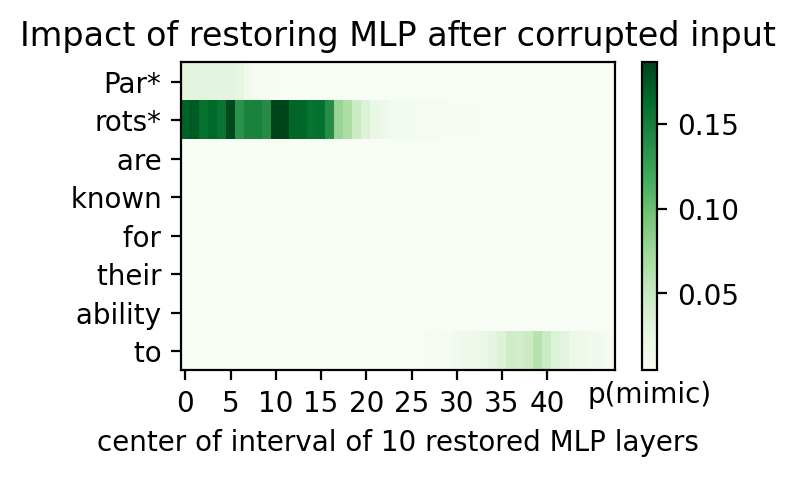

Threshold:  tensor(0.0189)

Highly Activated Neurons:
Layer:  0  Token:  1
Layer:  1  Token:  1
Layer:  2  Token:  1
Layer:  22  Token:  7
Layer:  23  Token:  7
Layer:  24  Token:  7
Layer:  25  Token:  7
Layer:  26  Token:  7
Layer:  27  Token:  7
Layer:  28  Token:  7
Layer:  29  Token:  7
Layer:  30  Token:  7
Layer:  31  Token:  7
Layer:  32  Token:  7
Layer:  33  Token:  7
Layer:  34  Token:  7
Layer:  35  Token:  7
Layer:  36  Token:  7



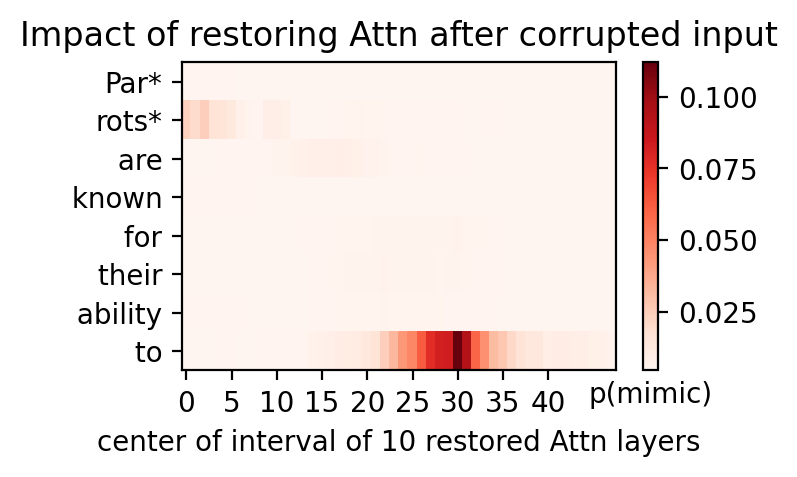

In [ ]:
plot_all_flow(mt, "Parrots are known for their ability to", noise=noise_level)

Threshold:  tensor(0.0811)

Highly Activated Neurons:
Layer:  9  Token:  3
Layer:  10  Token:  3
Layer:  11  Token:  3
Layer:  12  Token:  3
Layer:  13  Token:  3
Layer:  14  Token:  3
Layer:  15  Token:  3
Layer:  16  Token:  3
Layer:  17  Token:  3
Layer:  18  Token:  3
Layer:  19  Token:  3
Layer:  20  Token:  3
Layer:  21  Token:  3
Layer:  24  Token:  10
Layer:  25  Token:  10
Layer:  26  Token:  10
Layer:  27  Token:  10
Layer:  28  Token:  10
Layer:  29  Token:  10
Layer:  30  Token:  10
Layer:  31  Token:  10
Layer:  32  Token:  10
Layer:  33  Token:  10
Layer:  34  Token:  10
Layer:  35  Token:  10
Layer:  36  Token:  10
Layer:  37  Token:  10
Layer:  38  Token:  10
Layer:  39  Token:  10
Layer:  40  Token:  10
Layer:  41  Token:  10
Layer:  42  Token:  10
Layer:  43  Token:  10
Layer:  44  Token:  10
Layer:  45  Token:  10
Layer:  46  Token:  10
Layer:  47  Token:  10



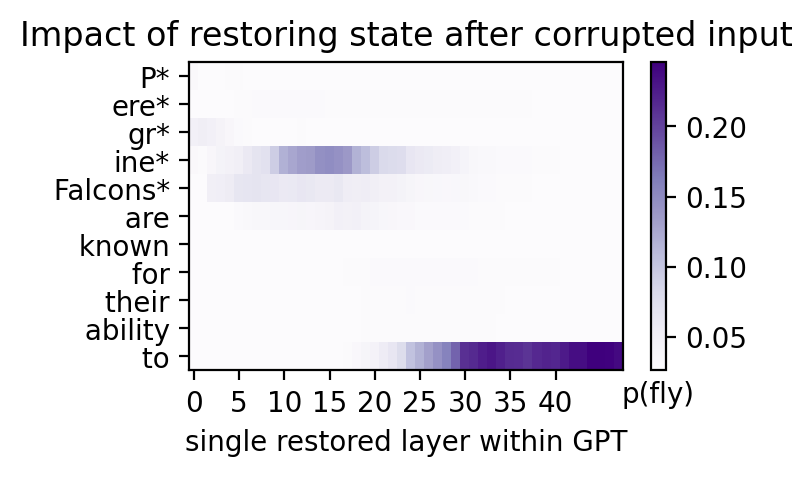

Threshold:  tensor(0.0419)

Highly Activated Neurons:
Layer:  0  Token:  2
Layer:  1  Token:  2
Layer:  2  Token:  2
Layer:  3  Token:  2
Layer:  4  Token:  2
Layer:  5  Token:  2
Layer:  6  Token:  2
Layer:  7  Token:  2
Layer:  8  Token:  2
Layer:  5  Token:  3
Layer:  6  Token:  3
Layer:  7  Token:  3
Layer:  8  Token:  3
Layer:  9  Token:  3
Layer:  11  Token:  3
Layer:  12  Token:  3
Layer:  13  Token:  3
Layer:  14  Token:  3
Layer:  15  Token:  3
Layer:  16  Token:  3
Layer:  17  Token:  3
Layer:  18  Token:  3
Layer:  19  Token:  3
Layer:  20  Token:  3
Layer:  21  Token:  3
Layer:  22  Token:  3
Layer:  6  Token:  4
Layer:  7  Token:  4
Layer:  9  Token:  4
Layer:  29  Token:  10
Layer:  31  Token:  10
Layer:  32  Token:  10
Layer:  33  Token:  10
Layer:  34  Token:  10
Layer:  35  Token:  10
Layer:  36  Token:  10
Layer:  37  Token:  10
Layer:  38  Token:  10
Layer:  39  Token:  10
Layer:  40  Token:  10



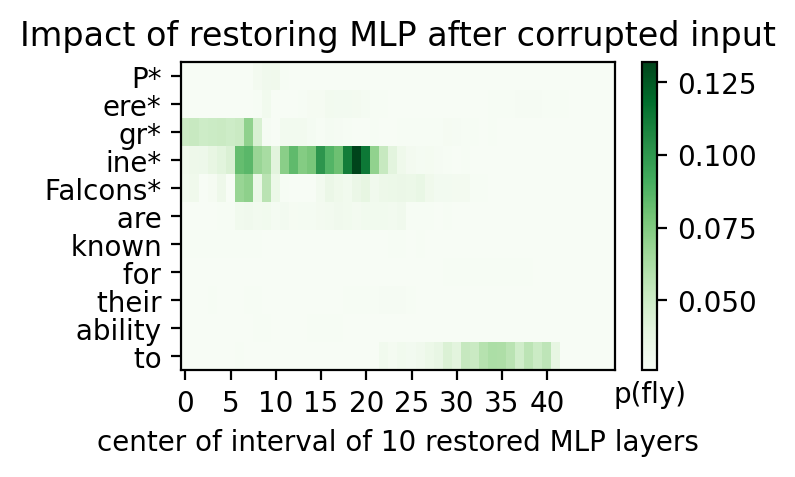

Threshold:  tensor(0.0485)

Highly Activated Neurons:
Layer:  14  Token:  4
Layer:  15  Token:  4
Layer:  16  Token:  4
Layer:  17  Token:  4
Layer:  18  Token:  4
Layer:  19  Token:  4
Layer:  20  Token:  4
Layer:  14  Token:  5
Layer:  15  Token:  5
Layer:  17  Token:  10
Layer:  18  Token:  10
Layer:  19  Token:  10
Layer:  20  Token:  10
Layer:  21  Token:  10
Layer:  22  Token:  10
Layer:  23  Token:  10
Layer:  24  Token:  10
Layer:  25  Token:  10
Layer:  26  Token:  10
Layer:  27  Token:  10
Layer:  28  Token:  10
Layer:  29  Token:  10
Layer:  30  Token:  10
Layer:  31  Token:  10
Layer:  32  Token:  10
Layer:  33  Token:  10
Layer:  34  Token:  10
Layer:  35  Token:  10
Layer:  36  Token:  10



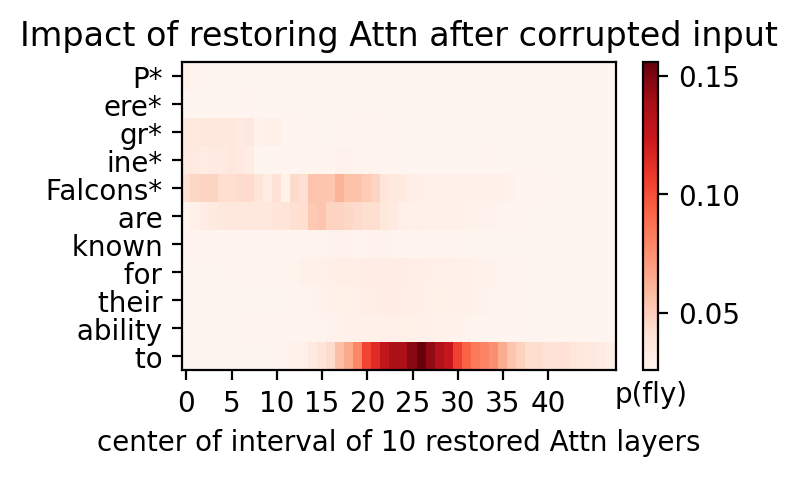

In [ ]:
plot_all_flow(mt, "Peregrine Falcons are known for their ability to", noise=noise_level)